# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.4723],
         [-0.6613]]),
 tensor([[ 1.0000e+00,  1.4723e+00,  1.0839e+00,  5.3193e-01,  1.9579e-01,
           5.7654e-02,  1.4148e-02,  2.9757e-03,  5.4764e-04,  8.9589e-05,
           1.3190e-05,  1.7655e-06,  2.1662e-07,  2.4533e-08,  2.5800e-09,
           2.5324e-10,  2.3303e-11,  2.0182e-12,  1.6508e-13,  1.2792e-14],
         [ 1.0000e+00, -6.6132e-01,  2.1867e-01, -4.8205e-02,  7.9698e-03,
          -1.0541e-03,  1.1619e-04, -1.0977e-05,  9.0739e-07, -6.6676e-08,
           4.4094e-09, -2.6510e-10,  1.4610e-11, -7.4320e-13,  3.5107e-14,
          -1.5478e-15,  6.3975e-17, -2.4887e-18,  9.1436e-20, -3.1826e-21]]),
 tensor([5.8537, 3.2738]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss) / 2,
                                     evaluate_loss(net, test_iter, loss) / 2))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 5.008179  1.18655  -3.419837  5.591411]]


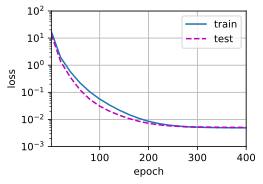

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[3.1912546 4.565581 ]]


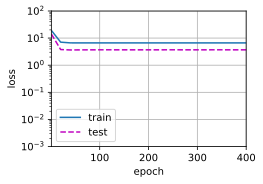

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 5.0118055   1.2975546  -3.4363704   5.0610976  -0.01485763  1.2479
   0.1788039   0.33407977 -0.09408445 -0.16420157 -0.05785279 -0.05275712
   0.15180825 -0.16987784  0.07128291 -0.01090476  0.09167246 -0.01612341
  -0.0419187   0.15163995]]


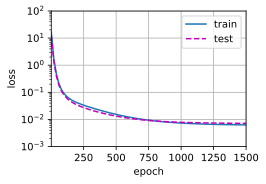

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)